In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
from os import walk
import matplotlib.image as mpimg
import cv2

Using TensorFlow backend.


In [0]:
# dimension of the latent space (min 2)
latent_dim = 512
image_dim = 64

#DATA

In [3]:
!unzip augmented.zip

Archive:  augmented.zip
 extracting: augmented/1.png         
 extracting: augmented/10.png        
 extracting: augmented/100.png       
 extracting: augmented/1000.png      
 extracting: augmented/10000.png     
 extracting: augmented/10001.png     
 extracting: augmented/10002.png     
 extracting: augmented/10003.png     
 extracting: augmented/10004.png     
 extracting: augmented/10005.png     
 extracting: augmented/10006.png     
 extracting: augmented/10007.png     
 extracting: augmented/10008.png     
 extracting: augmented/10009.png     
 extracting: augmented/1001.png      
 extracting: augmented/10010.png     
 extracting: augmented/10011.png     
 extracting: augmented/10012.png     
 extracting: augmented/10013.png     
 extracting: augmented/10014.png     
 extracting: augmented/10015.png     
 extracting: augmented/10016.png     
 extracting: augmented/10017.png     
 extracting: augmented/10018.png     
 extracting: augmented/10019.png     
 extracting: augmented/100

In [0]:
#----------------------------------------------------------------------------
# Read the dataset
#----------------------------------------------------------------------------
imgs = []

f = []
for (dirpath, dirnames, filenames) in walk('augmented'):
    f.extend(filenames)

for src in f:
    #read PNG images and convert them to RGB tensors
    img = mpimg.imread('augmented/' + src)[:,:,0:3]
    img = cv2.resize(img, (image_dim,image_dim))
    imgs.append(img)
    
imgs = np.array(imgs)

# 64
image_size = imgs.shape[1]
# 64x64x3
input_shape = (image_size, image_size, 3)

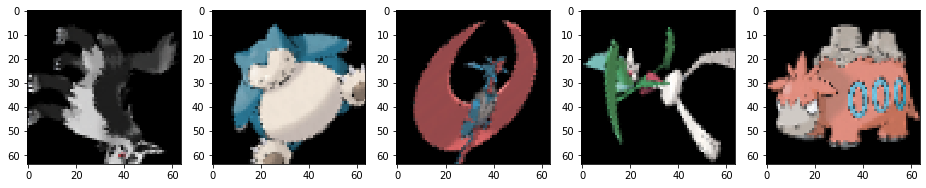

In [5]:
# show some of them
f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)
for i in range(5):
    img = imgs[i]
    axarr[i].imshow(img)
plt.show()

# VAE MODEL

## ENCODER

In [0]:
# reparameterization trick
# z = mean + sqrt(var)*eps
# where only eps is random, we can backprop on the other parameters
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=64, kernel_size=2, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(x)     
x = Conv2D(filters=256, kernel_size=3, activation='relu', strides=2, padding='same')(x)   

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(latent_dim*2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()





Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   8256        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 8, 8, 128)    73856       conv2d_2[0][0]                   
________________________________________________________________________________________

## DECODER

In [8]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

#x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=256, kernel_size=5, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=128, kernel_size=5, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=32, kernel_size=2, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
outputs = Conv2DTranspose(filters=3, kernel_size=2, activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()









Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         1638656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)   

## VAE

In [0]:
# out = D(E(x))
# where E(x)=z
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [10]:
# VAE loss = xent_loss + kl_loss
# or mse(,)
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= image_size * image_size

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# compile VAE with loss
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 64, 64, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 512), (None, 512) 5623104   
_________________________________________________________________
decoder (Model)              (None, 64, 64, 3)         4643555   
Total params: 10,266,659
Trainable params: 10,265,699
Non-trainable params: 960
_________________________________________________________________


# TRAIN

In [12]:
# train parameters
batch_size = 256
epochs = 800

vae.fit(imgs, epochs=epochs, batch_size=batch_size, validation_data=(imgs, None))
vae.save_weights('vae_cnn_cifar.h5')



Train on 16380 samples, validate on 16380 samples
Epoch 1/800
16380/16380 [==============================] - 13s 818us/step - loss: 2284.2397 - val_loss: 1746.0181
Epoch 2/800
16380/16380 [==============================] - 8s 463us/step - loss: 1689.4238 - val_loss: 1624.7409
Epoch 3/800
16380/16380 [==============================] - 8s 464us/step - loss: 1592.8875 - val_loss: 1557.6706
Epoch 4/800
16380/16380 [==============================] - 7s 457us/step - loss: 1550.4944 - val_loss: 1544.9078
Epoch 5/800
16380/16380 [==============================] - 8s 461us/step - loss: 1528.7092 - val_loss: 1513.1698
Epoch 6/800
16380/16380 [==============================] - 8s 461us/step - loss: 1502.9540 - val_loss: 1488.1079
Epoch 7/800
16380/16380 [==============================] - 8s 460us/step - loss: 1488.9475 - val_loss: 1479.1380
Epoch 8/800
16380/16380 [==============================] - 8s 460us/step - loss: 1477.0551 - val_loss: 1463.6044
Epoch 9/800
16380/16380 [==================

# PLOT

In [0]:
def plot_results(encoder, decoder, x_test, y_test, batch_size=128, model_name="vae_cifar"):
    
    # display a nxn 2D manifold of images
    n = 10
    img_size = image_dim
    figure = np.zeros((img_size * n, img_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]

  # display a 2D plot of the image classes in the first 2 dimensions of the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(n, n))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

  # display the generated images along the first 2 dimensions of the latent space
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.random.normal(0.0, 1, (1,latent_dim))
            # the first two dim is given
            z_sample[0,0]=xi
            z_sample[0,1]=yi
            # generate an image from the latent representation
            x_decoded = decoder.predict(z_sample)
            img = x_decoded[0].reshape(img_size, img_size, 3)

            #sharpen image
            #kernel_sharpening = np.array([[-1,-1,-1], [-1, 9,-1], [-1,-1,-1]])
            #img = cv2.filter2D(img, -1, kernel_sharpening)

            figure[i * img_size: (i + 1) * img_size,
                   j * img_size: (j + 1) * img_size,] = img

    plt.figure(figsize=(20, 20))
    start_range = img_size // 2
    end_range = n * img_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()



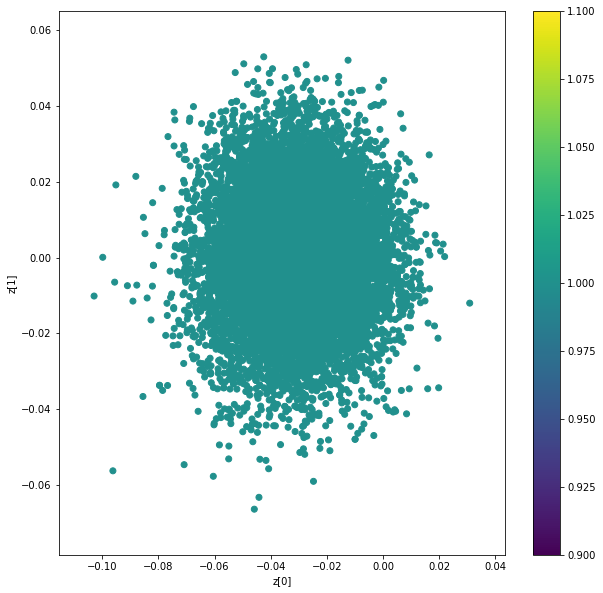

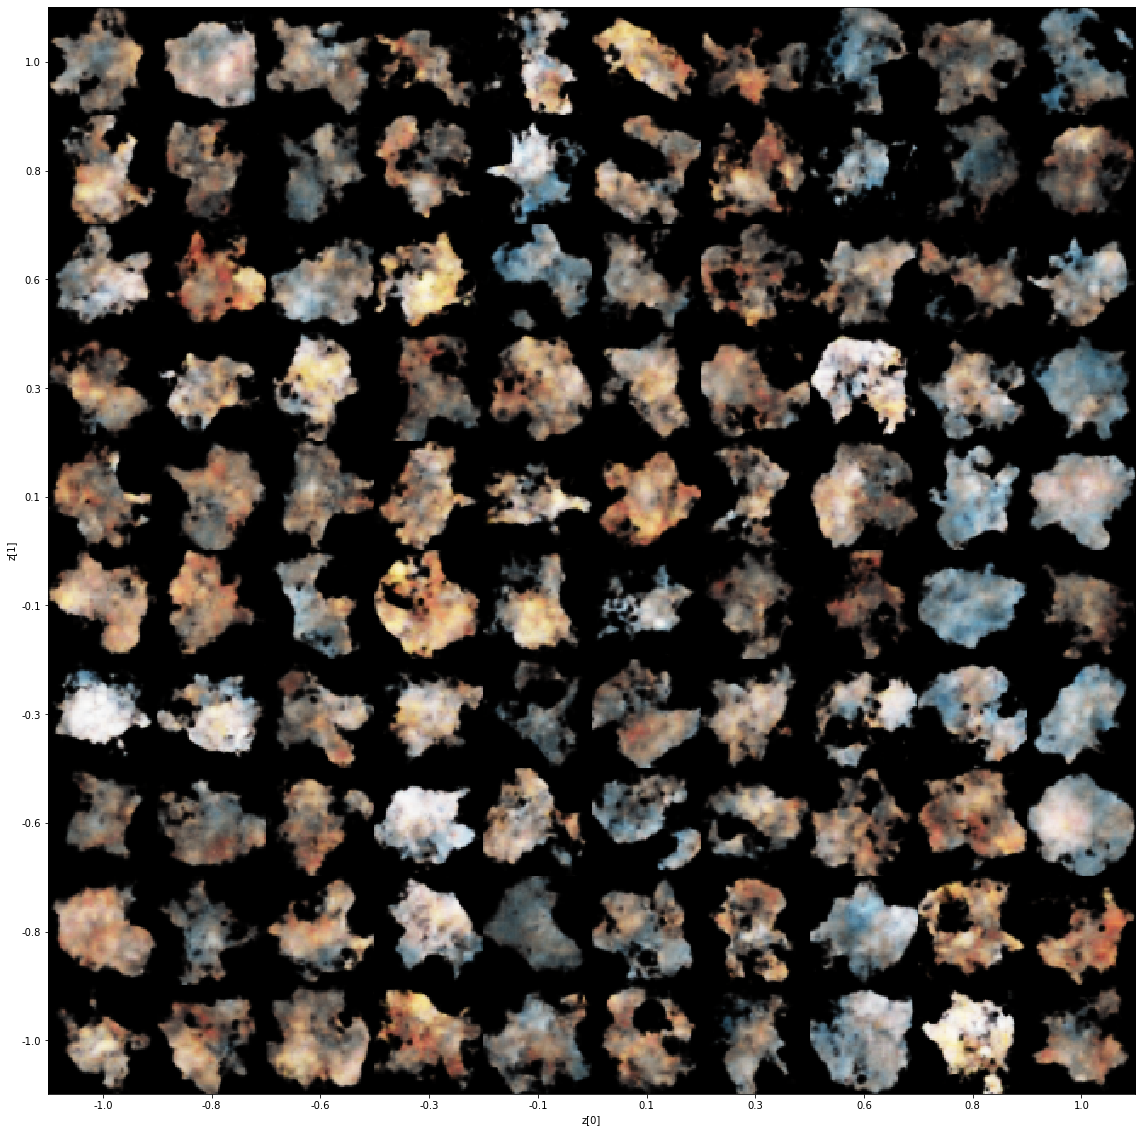

In [21]:
# now we have only one class
plot_results(encoder, decoder, imgs, np.ones((imgs.shape[0])), batch_size=batch_size, model_name="vae_cnn")